In [1]:
# All necessary imports
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models

from PIL import Image

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import SoftmaxLikelihood

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# This block of code will make everything run on the same seed, so the results stay the same every runtime.

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If you're using GPU

# Ensure deterministic behavior for PyTorch (may slow down training slightly)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seed set to: {seed}")

Seed set to: 42


In [3]:
# CustomImageDataset: A PyTorch Dataset class for loading images and their corresponding labels.
# - __init__: Initializes the dataset with directories for images and labels, along with optional transformations.
# - __len__: Returns the total number of image files in the dataset.
# - __getitem__: Fetches an image and its corresponding label by index. Handles missing or malformed labels by
#                assigning a default invalid value (-1) for debugging purposes. Applies any specified transformations
#                to the image before returning it.

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image path
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        # Get corresponding label path
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load label
        try:
            with open(label_path, 'r') as file:
                line = file.readline().strip()
                if line:
                    class_id = int(line.split()[0])  # Extract class_id
                else:
                    raise ValueError(f"Empty label file: {label_path}")
        except (IndexError, ValueError) as e:
            print(f"Skipping malformed label file: {label_path}. Error: {e}")
            class_id = -1  # Assign an invalid label for debugging purposes

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, class_id


In [4]:
# Define the directory paths for training, validation, and test datasets.
# Each dataset includes separate directories for images and corresponding label files.

train_image_dir = r'datasets/car/train/images'
train_label_dir = r'datasets/car/train/labels'

val_image_dir = r'datasets/car/valid/images'
val_label_dir = r'datasets/car/valid/labels'

test_image_dir = r'datasets/car/test/images'
test_label_dir = r'datasets/car/test/labels'

In [5]:
# Define a sequence of data transformations for preprocessing images.
# - Resize: Scales images to 224x224 pixels (common input size for many CNNs).
# - ToTensor: Converts the image to a PyTorch tensor and scales pixel values to [0, 1].
# - Normalize: Normalizes the tensor using the specified mean and standard deviation values,
#              which are standard for pre-trained ImageNet models.

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Create dataset objects for training, validation, and test data using the CustomImageDataset class.
# - Each dataset applies the defined transformations to preprocess the images.
# - DataLoader objects are created for each dataset to efficiently load data in batches.
#   - train_loader: Loads training data in batches of 32 with shuffling to randomize the order.
#   - val_loader: Loads validation data in batches of 32 without shuffling.
#   - test_loader: Loads test data in batches of 32 without shuffling.

train_dataset = CustomImageDataset(train_image_dir, train_label_dir, transform=data_transforms)
val_dataset = CustomImageDataset(val_image_dir, val_label_dir, transform=data_transforms)
test_dataset = CustomImageDataset(test_image_dir, test_label_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Determine the number of classes
label_files = os.listdir(train_label_dir)
class_ids = []

for label_file in label_files:
    label_path = os.path.join(train_label_dir, label_file)
    with open(label_path, 'r') as file:
        line = file.readline().strip()
        if line:  # Ensure the line is not empty
            try:
                class_id = int(line.split()[0])  # Extract the first number as the class ID
                class_ids.append(class_id)
            except (ValueError, IndexError):
                print(f"Malformed label in file: {label_file}")
        else:
            print(f"Empty label file: {label_file}")

# Calculate the number of unique classes
num_classes = len(set(class_ids))
print(f"Number of classes: {num_classes}")

Empty label file: FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt
Empty label file: FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt
Empty label file: FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt
Number of classes: 15


In [ ]:
# Filter datasets to exclude samples with invalid labels (-1) and update DataLoaders.
# - get_valid_indices: Identifies valid data indices.
# - Create filtered datasets with only valid samples.
# - Update DataLoaders for filtered datasets and print their sizes.

# Filter valid indices where labels are not -1
def get_valid_indices(dataset):
    valid_indices = [i for i in range(len(dataset)) if dataset[i][1] != -1]
    return valid_indices

# Get valid indices for train, val, and test datasets
train_valid_indices = get_valid_indices(train_dataset)
val_valid_indices = get_valid_indices(val_dataset)
test_valid_indices = get_valid_indices(test_dataset)

# Create filtered datasets
train_dataset_filtered = Subset(train_dataset, train_valid_indices)
val_dataset_filtered = Subset(val_dataset, val_valid_indices)
test_dataset_filtered = Subset(test_dataset, test_valid_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset_filtered, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_filtered, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_filtered, batch_size=32, shuffle=False)

# Verify DataLoaders
print(f"Filtered train dataset size: {len(train_dataset_filtered)}")
print(f"Filtered val dataset size: {len(val_dataset_filtered)}")
print(f"Filtered test dataset size: {len(test_dataset_filtered)}")

Skipping malformed label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt. Error: Empty label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.txt
Skipping malformed label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt. Error: Empty label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.txt
Skipping malformed label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt. Error: Empty label file: C:/Users/mattr/archive (1)/car/train/labels\FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.txt
Skipping malformed label file: C:/Users/mattr/archive (1)/car/test/labels\FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.txt. Error: Empty label file: C:/

In [ ]:
# Load and modify a pretrained ResNet-18 model for feature extraction.
# - Remove the classification layer to extract features (output shape: [batch_size, 512]).
# - Freeze all layers initially and selectively unfreeze the last two blocks for fine-tuning.
# - Apply transformations for preprocessing and move the model to the device.

# Define a function to extract features and labels from a DataLoader.
# - extract_features: Passes data through the model to extract features, storing them along with labels.
# - Extract features and labels for train, validation, and test sets using the feature extractor.

# Print the shapes of the extracted features and labels for verification.

# Load pretrained ResNet-18 model
feature_extractor = models.resnet18(pretrained=True)

# Remove the classification layer to output features instead of logits
feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])

# Fine-tune all layers or only specific layers
for param in feature_extractor.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Unfreeze the last two blocks of ResNet for fine-tuning
for param in list(feature_extractor.children())[-2:]:
    for p in param.parameters():
        p.requires_grad = True  # Allow gradient updates for fine-tuning

# Move feature extractor to device
feature_extractor = feature_extractor.to(device)

# Dataset and transforms
transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extract features
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

def extract_features(loader, feature_extractor):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            # Extract features and flatten to [batch_size, 512]
            batch_features = feature_extractor(images).squeeze(-1).squeeze(-1)
            features.append(batch_features.cpu())
            labels.append(targets.cpu())
    return torch.cat(features), torch.cat(labels)

# Extract features for train, validation, and test sets
train_features, train_labels = extract_features(train_loader, feature_extractor)
val_features, val_labels = extract_features(val_loader, feature_extractor)  # Add validation set
test_features, test_labels = extract_features(test_loader, feature_extractor)

print(f"Train features: {train_features.shape}, Train labels: {train_labels.shape}")
print(f"Validation features: {val_features.shape}, Validation labels: {val_labels.shape}")  # Add this line
print(f"Test features: {test_features.shape}, Test labels: {test_labels.shape}")

c:\Users\mattr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mattr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train features: torch.Size([3527, 512]), Train labels: torch.Size([3527])
Validation features: torch.Size([801, 512]), Validation labels: torch.Size([801])
Test features: torch.Size([637, 512]), Test labels: torch.Size([637])


In [ ]:
# Define a simple fully connected neural network for classification tasks.
# - SimpleCNN: A PyTorch neural network module designed for processing feature vectors.
# - __init__: Initializes two fully connected (fc) layers:
#   - fc1: Maps input features (from ResNet) to 128 hidden units.
#   - fc2: Outputs predictions for the specified number of classes.
# - forward: Defines the forward pass:
#   - Applies ReLU activation after the first layer.
#   - Outputs logits for class predictions from the second layer.

class SimpleCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Input dim is the feature size from ResNet
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Define a smaller fully connected neural network for classification tasks.
# - SmallerCNN: A PyTorch module optimized for simpler tasks or smaller datasets.
# - __init__: Initializes two fully connected (fc) layers:
#   - fc1: Maps input features (from ResNet) to 64 hidden units.
#   - fc2: Outputs logits for the specified number of classes.
# - forward: Defines the forward pass:
#   - Applies ReLU activation after the first layer.
#   - Outputs class logits from the second layer.

class SmallerCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SmallerCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Input dim is the feature size from ResNet
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Train a SimpleCNN model using features extracted from ResNet with early stopping.
# - Initialize the model with the ResNet feature dimension and the number of classes.
# - Define the loss function (CrossEntropyLoss) and the Adam optimizer.
# - Configure early stopping: monitor validation loss and stop training after a set patience period.
# - Prepare PyTorch DataLoaders for training and validation using the extracted features and labels.

# Training loop:
# - Iterates over epochs and batches to train the model.
# - For each batch, performs a forward pass, computes loss, backpropagates gradients, and updates weights.
# - Tracks training loss and accuracy for monitoring performance.

# Validation loop:
# - Evaluates the model on the validation set without updating weights.
# - Computes validation loss and accuracy to monitor performance improvements.

# Early stopping:
# - Saves the model weights whenever a lower validation loss is achieved.
# - Stops training if no improvement is observed for a specified number of epochs.

# Save the best and final model weights to disk for later use.

# Initialize the model
input_dim = 512  # Feature dimension from ResNet
model = SimpleCNN(input_dim=input_dim, num_classes=num_classes).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100  # Increase epochs for flexibility
patience = 10  # Number of epochs to wait before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Prepare data loaders for extracted features
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_features, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.train()
print("Training SimpleCNN with Early Stopping...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for features, labels in train_loader:  # Use extracted features and labels
        features, labels = features.to(device), labels.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)  # Pass extracted features
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for features, labels in val_loader:  # Use extracted validation features and labels
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)  # Pass extracted features
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(outputs, 1)
            correct_val += (val_predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)  # Average validation loss
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    model.train()  # Switch back to training mode

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_simplecnn.pth")  # Save the best model
        print("Best model saved!")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Best Validation Loss: {best_val_loss:.4f}")
        break

print("Training Complete.")
torch.save(model.state_dict(), "simple_cnn_weights.pth")
print("Model weights saved as 'simple_cnn_weights.pth'")

SimpleCNN(
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=15, bias=True)
)
Training SimpleCNN with Early Stopping...
Epoch 1/100, Loss: 225.2688, Accuracy: 0.3434
Validation Loss: 1.7085, Validation Accuracy: 0.4444
Best model saved!
Epoch 2/100, Loss: 169.9322, Accuracy: 0.4877
Validation Loss: 1.4840, Validation Accuracy: 0.4931
Best model saved!
Epoch 3/100, Loss: 146.6615, Accuracy: 0.5671
Validation Loss: 1.3247, Validation Accuracy: 0.5518
Best model saved!
Epoch 4/100, Loss: 132.5690, Accuracy: 0.6022
Validation Loss: 1.2861, Validation Accuracy: 0.5655
Best model saved!
Epoch 5/100, Loss: 121.0674, Accuracy: 0.6374
Validation Loss: 1.2441, Validation Accuracy: 0.5668
Best model saved!
Epoch 6/100, Loss: 113.5727, Accuracy: 0.6504
Validation Loss: 1.1627, Validation Accuracy: 0.5693
Best model saved!
Epoch 7/100, Loss: 104.2363, Accuracy: 0.6850
Validation Loss: 1.0914, Validation Accuracy: 0.6242
Best model saved!
Epo

Accuracy: 0.6782
Number of predictions taking longer than 1 ms: 0
Average time per prediction (ms): 0.0126


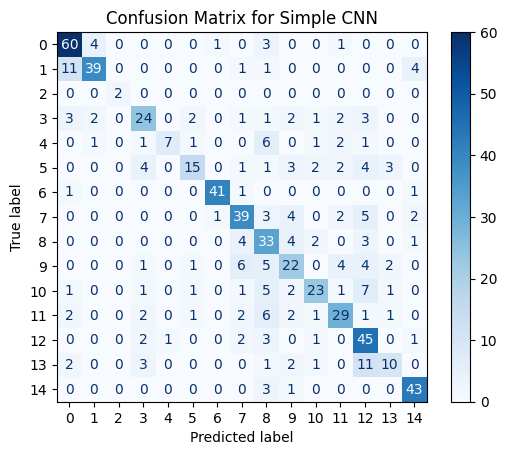

Uncertainties saved to 'uncertainties_simpleNN.npy'


In [ ]:
# Evaluate the trained SimpleCNN model on the test dataset using extracted features.
# - Create a DataLoader for the test dataset with features and labels.
# - Set the model to evaluation mode to disable gradient calculations and dropout.

# Inference:
# - For each batch, measure per-sample prediction times in milliseconds.
# - Use softmax to compute class probabilities and predict the most probable class.
# - Collect predictions, true labels, and variance proxies (probabilities variance as a measure of uncertainty).

# Metrics:
# - Calculate accuracy of predictions and generate a confusion matrix.
# - Analyze timing: count predictions exceeding a specified time threshold and calculate average per-sample time.

# Visualization:
# - Display a confusion matrix to assess model performance across all classes.

# Save Results:
# - Save computed uncertainties (variance proxies) to a file for further analysis.

# Create DataLoader for extracted test features and labels
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set model to evaluation mode
model.eval()

# Initialize lists to store results
all_predictions = []
all_true_labels = []
prediction_times = []  # To store per-prediction times
all_variance_proxies = []  # To store uncertainty proxies (variance of probabilities)

# Perform inference
with torch.no_grad():
    for features, labels in test_loader:  # Use features instead of images
        features, labels = features.to(device), labels.to(device)  # Move data to device
        start_time = time.time()  # Start timing
        outputs = model(features)  # Forward pass with extracted features
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(probabilities, 1)  # Get predictions
        end_time = time.time()  # End timing

        # Calculate batch inference time in milliseconds
        batch_time = (end_time - start_time) * 1000  # Batch time in ms
        batch_size = len(labels)  # Number of predictions in this batch
        per_prediction_time = batch_time / batch_size  # Average per-sample time

        # Record per-prediction time for each sample in the batch
        prediction_times.extend([per_prediction_time] * batch_size)

        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())  # Move predictions to CPU
        all_true_labels.extend(labels.cpu().numpy())  # Move labels to CPU

        # Compute variance proxy for uncertainty
        variance_proxy = probabilities.var(dim=1).cpu().numpy()  # Variance across classes
        all_variance_proxies.extend(variance_proxy)

# Bundle variance proxies for later use
uncertainties_simpleNN = np.array(all_variance_proxies)

# Calculate metrics
accuracy_NN = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
threshold = 1  # Define the threshold in milliseconds
times_exceeding_threshold_NN = sum(1 for t in prediction_times if t > threshold)
average_time_per_prediction_NN = np.mean(prediction_times)

# Output evaluation metrics
print(f"Accuracy: {accuracy_NN:.4f}")
print(f"Number of predictions taking longer than {threshold} ms: {times_exceeding_threshold_NN}")
print(f"Average time per prediction (ms): {average_time_per_prediction_NN:.4f}")

# Display confusion matrix
class_names = train_dataset.classes if hasattr(train_dataset, "classes") else range(num_classes)  # Class names
ConfusionMatrixDisplay.from_predictions(
    all_true_labels,
    all_predictions,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.title("Confusion Matrix for Simple CNN")
plt.show()

# Save uncertainties for further analysis
np.save("uncertainties_simpleNN.npy", uncertainties_simpleNN)  # Save to a file
print("Uncertainties saved to 'uncertainties_simpleNN.npy'")

Accuracy with MC Dropout: 0.6782
Number of predictions taking longer than 1 ms: 0
Average time per prediction with MC Dropout (ms): 0.3817


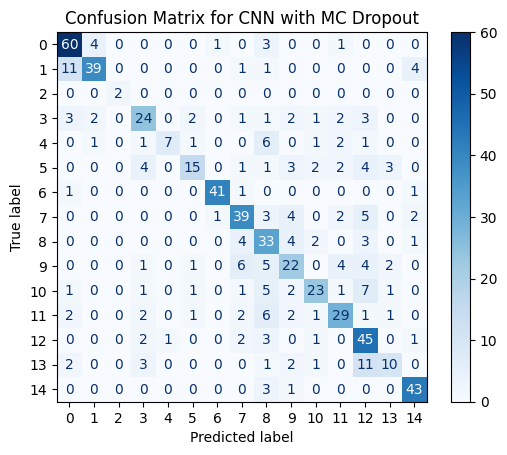

Uncertainties saved to 'uncertainties_mc_dropout.npy'


In [ ]:
# Perform inference with Monte Carlo (MC) Dropout for uncertainty estimation.
# - enable_dropout: A function to activate dropout layers during inference.
# - Use multiple stochastic forward passes (n_passes) to compute predictions and uncertainty estimates.

# Inference:
# - For each batch, collect predictions from multiple stochastic forward passes with active dropout.
# - Compute the mean prediction for final class determination.
# - Calculate variance across stochastic predictions as an uncertainty measure.

# Metrics:
# - Calculate accuracy using the mean predictions.
# - Generate a confusion matrix to evaluate class-wise performance.
# - Analyze timing: count predictions exceeding a defined time threshold and compute the average per-sample time.

# Visualization:
# - Display a confusion matrix showing prediction performance.

# Save Results:
# - Save computed uncertainties (variances across stochastic passes) for further analysis.

# Function to enable dropout during inference
def enable_dropout(model):
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()


# Enable dropout layers for MC Dropout
enable_dropout(model)

# Create DataLoader for extracted test features and labels
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variances = []  # Variance across stochastic forward passes for uncertainty
prediction_times = []  # To store per-prediction times

# Set number of stochastic passes
n_passes = 50

# Test the model with MC Dropout
with torch.no_grad():
    for features, labels in test_loader:  # Use extracted features
        features, labels = features.to(device), labels.to(device)  # Move data to device

        # Start timing
        start_time = time.time()

        # Collect predictions from multiple forward passes
        stochastic_outputs = []
        for _ in range(n_passes):
            logits = model(features)  # Forward pass with extracted features
            probabilities = F.softmax(logits, dim=1)  # Convert to probabilities
            stochastic_outputs.append(probabilities.cpu().numpy())

        # End timing
        end_time = time.time()

        # Calculate batch inference time in milliseconds
        batch_time = (end_time - start_time) * 1000  # Batch time in ms
        batch_size = len(labels)  # Number of predictions in this batch
        per_prediction_time = batch_time / batch_size  # Average per-sample time

        # Record per-prediction time for each sample in the batch
        prediction_times.extend([per_prediction_time] * batch_size)

        # Convert list of predictions to a NumPy array
        stochastic_outputs = np.array(stochastic_outputs)  # Shape: (n_passes, batch_size, num_classes)

        # Compute the mean prediction (for final class prediction)
        mean_prediction = stochastic_outputs.mean(axis=0)  # Shape: (batch_size, num_classes)
        predicted_classes = mean_prediction.argmax(axis=1)  # Predicted classes

        # Compute variance across the stochastic passes (for uncertainty)
        variances = stochastic_outputs.var(axis=0).mean(axis=1)  # Mean variance per sample

        # Store results
        all_predictions.extend(predicted_classes)
        all_true_labels.extend(labels.cpu().numpy())  # Move labels to CPU
        all_variances.extend(variances)

# Calculate metrics
accuracy_MC = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
threshold = 1  # Define the threshold in milliseconds
times_exceeding_threshold_MC = sum(1 for t in prediction_times if t > threshold)
average_time_per_prediction_MC = np.mean(prediction_times)

# Output results
print(f"Accuracy with MC Dropout: {accuracy_MC:.4f}")
print(f"Number of predictions taking longer than {threshold} ms: {times_exceeding_threshold_MC}")
print(f"Average time per prediction with MC Dropout (ms): {average_time_per_prediction_MC:.4f}")

# Display confusion matrix
class_names = train_dataset.classes if hasattr(train_dataset, "classes") else range(num_classes)  # Class names
ConfusionMatrixDisplay.from_predictions(
    all_true_labels,
    all_predictions,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.title("Confusion Matrix for CNN with MC Dropout")
plt.show()

# Bundle variances for later use
uncertainties_mc_dropout = np.array(all_variances)

# Save uncertainties
np.save("uncertainties_mc_dropout.npy", uncertainties_mc_dropout)
print("Uncertainties saved to 'uncertainties_mc_dropout.npy'")

In [ ]:
# Train an ensemble of models using bagging and save their weights.
# - Create a directory (`ensemble_dir`) to store the trained weights for each ensemble model.
# - Define the ensemble size (`n_models`), specifying how many models to train.
# - Use SmallerCNN as the base model for each ensemble member.

# Training loop for each model in the ensemble:
# - Initialize a new model instance for each ensemble member.
# - Use the Adam optimizer and CrossEntropyLoss criterion for training.
# - Train each model on the extracted training features for a specified number of epochs (`num_epochs`).
# - Save the trained weights for each model to the ensemble directory for later use.

# Result:
# - Trained models are added to the ensemble list for potential use in ensemble predictions.
# - All model weights are saved to disk for reproducibility or further analysis.

# Directory to save ensemble weights
ensemble_dir = "bagging_ensemble_weights"
os.makedirs(ensemble_dir, exist_ok=True)

# Define ensemble parameters
n_models = 10  # Number of models in the ensemble

# Initialize ensemble
ensemble = []

# Prepare DataLoader for extracted features
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}...")

    # Create a new instance of the model
    model = SmallerCNN(input_dim=512, num_classes=num_classes).to(device)  # Adjusted for extracted features

    # Use the same optimizer and criterion as before
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Train the model on the extracted training data
    model.train()
    num_epochs = 50 
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for features, labels in train_loader:  # Use extracted features and labels
            features, labels = features.to(device), labels.to(device)  # Move data to device

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

        print(f"Model {i + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the model's weights
    model_path = os.path.join(ensemble_dir, f"model_{i + 1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved model {i + 1} weights to {model_path}.")

    # Add the trained model to the ensemble
    ensemble.append(model)

print(f"All {n_models} models in the ensemble have been trained and saved.")

Training model 1/10...
Model 1, Epoch 1/50, Loss: 243.4876
Model 1, Epoch 2/50, Loss: 188.4769
Model 1, Epoch 3/50, Loss: 166.5576
Model 1, Epoch 4/50, Loss: 150.6307
Model 1, Epoch 5/50, Loss: 140.7244
Model 1, Epoch 6/50, Loss: 130.8832
Model 1, Epoch 7/50, Loss: 123.8806
Model 1, Epoch 8/50, Loss: 116.6427
Model 1, Epoch 9/50, Loss: 112.8204
Model 1, Epoch 10/50, Loss: 107.6798
Model 1, Epoch 11/50, Loss: 102.8036
Model 1, Epoch 12/50, Loss: 99.1108
Model 1, Epoch 13/50, Loss: 95.6186
Model 1, Epoch 14/50, Loss: 91.4152
Model 1, Epoch 15/50, Loss: 88.1255
Model 1, Epoch 16/50, Loss: 86.7883
Model 1, Epoch 17/50, Loss: 84.0140
Model 1, Epoch 18/50, Loss: 81.4767
Model 1, Epoch 19/50, Loss: 78.1682
Model 1, Epoch 20/50, Loss: 75.8927
Model 1, Epoch 21/50, Loss: 73.4852
Model 1, Epoch 22/50, Loss: 71.3479
Model 1, Epoch 23/50, Loss: 68.6873
Model 1, Epoch 24/50, Loss: 68.3949
Model 1, Epoch 25/50, Loss: 67.1491
Model 1, Epoch 26/50, Loss: 64.3667
Model 1, Epoch 27/50, Loss: 63.6202
Mod

Accuracy with Bagging Ensemble: 0.6907
Number of predictions taking longer than 1 ms: 0
Average time per prediction with Bagging Ensemble (ms): 0.0686


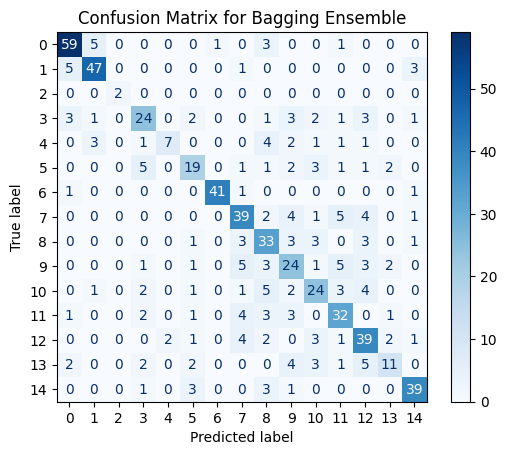

array([5.05669974e-03, 2.22457107e-03, 2.74463581e-08, 1.13846174e-04,
       8.65980255e-05, 3.40602710e-04, 8.66912796e-06, 1.45175516e-08,
       4.29274332e-05, 9.40372047e-09, 4.09717993e-09, 6.86684297e-03,
       8.28511020e-08, 3.99187068e-03, 3.99187068e-03, 1.28530839e-08,
       5.00736119e-09, 1.20410506e-04, 2.21635753e-04, 3.21100970e-06,
       1.72144428e-05, 3.11828277e-04, 3.51141061e-05, 1.81877505e-04,
       2.35012576e-05, 6.03826820e-08, 5.07388380e-04, 8.52791825e-04,
       1.65852562e-05, 8.66734656e-04, 1.69259096e-07, 5.71181699e-05,
       6.81603997e-05, 1.43330262e-05, 1.11337215e-06, 1.11337215e-06,
       7.86504534e-05, 9.33744531e-08, 7.09473461e-05, 7.09473461e-05,
       1.21703539e-02, 9.29282885e-03, 5.14050340e-03, 4.09208331e-03,
       4.55162209e-03, 5.44459233e-03, 8.76085658e-04, 3.23919114e-03,
       3.76087701e-05, 1.20864235e-04, 5.35452331e-04, 6.41742768e-03,
       4.59018024e-03, 2.73424725e-04, 4.00315970e-03, 1.17008940e-05,
      

In [ ]:
# Evaluate the ensemble of models using bagging for improved predictions and uncertainty estimation.
# - Set all ensemble models to evaluation mode.
# - Use the ensemble to predict classes and estimate uncertainties for the test dataset.

# Inference:
# - For each batch, collect predictions (probabilities) from all models in the ensemble.
# - Compute the mean prediction for final class determination.
# - Calculate variance across ensemble predictions as an uncertainty proxy.
# - Measure the average time taken for predictions per sample.

# Metrics:
# - Calculate overall accuracy of the ensemble using mean predictions.
# - Generate a confusion matrix to evaluate the ensemble's class-wise performance.
# - Analyze timing: count predictions exceeding a time threshold and compute the average per-sample time.

# Visualization:
# - Display a confusion matrix to visually assess model performance.

# Results:
# - Variance across ensemble predictions is stored as uncertainty.
# - Accuracy and timing metrics are output for further evaluation.

# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variances = []  # Variance across ensemble predictions for uncertainty
prediction_times = []  # To store per-prediction times

# Set the ensemble models to evaluation mode
for model in ensemble:
    model.eval()

# Create DataLoader for extracted test features and labels
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the ensemble
with torch.no_grad():
    for features, labels in test_loader:  # Use extracted features
        features, labels = features.to(device), labels.to(device)  # Move data to device

        # Start timing
        start_time = time.time()

        # Collect predictions from all models in the ensemble
        ensemble_outputs = []
        for model in ensemble:
            logits = model(features)  # Forward pass with extracted features
            probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
            ensemble_outputs.append(probabilities.cpu().numpy())

        # End timing
        end_time = time.time()

        # Calculate batch inference time in milliseconds
        batch_time = (end_time - start_time) * 1000  # Batch time in ms
        batch_size = len(labels)  # Number of predictions in this batch
        per_prediction_time = batch_time / batch_size  # Average per-sample time

        # Record per-prediction time for each sample in the batch
        prediction_times.extend([per_prediction_time] * batch_size)

        # Convert list of predictions to a NumPy array
        ensemble_outputs = np.array(ensemble_outputs)  # Shape: (n_models, batch_size, num_classes)

        # Compute mean prediction (for final class prediction)
        mean_prediction = ensemble_outputs.mean(axis=0)  # Shape: (batch_size, num_classes)
        predicted_classes = mean_prediction.argmax(axis=1)  # Predicted classes for the batch

        # Compute variance across ensemble predictions (for uncertainty)
        variance = ensemble_outputs.var(axis=0).mean(axis=1)  # Variance as uncertainty proxy

        # Store results
        all_predictions.extend(predicted_classes)
        all_true_labels.extend(labels.cpu().numpy())  # Move labels to CPU
        all_variances.extend(variance)

# Calculate metrics
accuracy_Bag = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
threshold = 1  # Define the threshold in milliseconds
times_exceeding_threshold_Bag = sum(1 for t in prediction_times if t > threshold)
average_time_per_prediction_Bag = np.mean(prediction_times)

# Output results
print(f"Accuracy with Bagging Ensemble: {accuracy_Bag:.4f}")
print(f"Number of predictions taking longer than {threshold} ms: {times_exceeding_threshold_Bag}")
print(f"Average time per prediction with Bagging Ensemble (ms): {average_time_per_prediction_Bag:.4f}")

# Display confusion matrix
class_names = train_dataset.classes if hasattr(train_dataset, "classes") else range(num_classes)  # Class names
ConfusionMatrixDisplay.from_predictions(
    all_true_labels,
    all_predictions,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.title("Confusion Matrix for Bagging Ensemble")
plt.show()

# Bundle variances for later use
uncertainties_bagging = np.array(all_variances)

# Return uncertainties for later use
uncertainties_bagging

In [ ]:
# Define a Neural Process (NP) model for probabilistic regression or meta-learning tasks.
# - Encoder: Encodes context data (inputs and outputs) into a latent distribution characterized by mean and variance.
#   - Input dimension includes both the input features and corresponding context outputs.
# - Decoder: Maps a sampled latent representation and query inputs to predictions.

# Components:
# - __init__: Defines the encoder, which outputs latent parameters (mean and log variance), and the decoder.
# - forward: Implements the forward pass of the Neural Process.
#   1. Concatenates context inputs (`context_x`) and outputs (`context_y`), encoding them into a latent distribution.
#   2. Uses the reparameterization trick to sample from the latent distribution (supports stochasticity).
#   3. Aggregates the latent representation across the context set (e.g., via mean pooling).
#   4. Matches the latent sample size to the batch size of query inputs (`query_x`).
#   5. Decodes the combined query inputs and latent representation to produce predictions.

# Output:
# - query_pred: Predicted outputs for the query inputs.
# - latent_dist: Latent distribution (mean and variance) for uncertainty estimation or sampling.

class NeuralProcess(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(NeuralProcess, self).__init__()
        # Encoder: Adjust input size to account for context_y
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # input_dim + 1 accounts for context_y
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Latent mean and variance
        )
        # Decoder: Predict outputs based on latent representation and query inputs
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, context_x, context_y, query_x):
        # Reshape context_y to match context_x
        context_y = context_y.unsqueeze(-1)  # Add a dimension: [context_size, 1]

        # Encode context set into latent distribution
        context = torch.cat([context_x, context_y], dim=-1)  # Concatenate inputs and outputs
        latent_params = self.encoder(context)  # [context_size, latent_dim * 2]
        latent_mean, latent_logvar = latent_params.chunk(2, dim=-1)

        # Reparameterization trick for latent sampling
        latent_std = torch.exp(0.5 * latent_logvar)
        latent_dist = torch.distributions.Normal(latent_mean, latent_std)
        latent_sample = latent_dist.rsample()  # [context_size, latent_dim]

        # Aggregate latent representation across the context set (e.g., mean pooling)
        latent_sample = latent_sample.mean(dim=0, keepdim=True)  # Aggregate to [1, latent_dim]

        # Match the latent representation to the query batch size
        batch_size = query_x.size(0)  # Get the batch size of query_x
        latent_sample = latent_sample.expand(batch_size, -1)  # Expand latent_sample to [batch_size, latent_dim]

        # Decode latent sample and query inputs to predict outputs
        query = torch.cat([query_x, latent_sample], dim=-1)  # Concatenate latent sample and query
        query_pred = self.decoder(query)

        return query_pred, latent_dist


In [ ]:
# Train a Neural Process (NP) model for probabilistic regression/classification using extracted features.

# Hyperparameters:
# - `input_dim`, `hidden_dim`, `latent_dim`, and `output_dim` define model architecture dimensions.
# - Early stopping is implemented with a patience of 5 epochs.
# - Class weights are computed to handle imbalanced datasets.

# Data Normalization:
# - Normalize features for training, validation, and testing datasets to ensure consistency.

# Training:
# - For each epoch, train the Neural Process using randomly sampled context sets.
# - Loss includes:
#   1. Reconstruction loss (cross-entropy for classification).
#   2. KL divergence between the latent distribution and a scaled standard normal prior.
#   3. Uncertainty regularization to penalize high variance in latent standard deviation.
# - Regularization coefficients (`beta` and `gamma`) control the relative importance of the KL term and uncertainty.

# Validation:
# - Evaluate the model on validation data to compute the reconstruction loss and KL divergence.
# - Apply early stopping based on validation loss to prevent overfitting.

# Output:
# - The best-performing model is saved to disk (`best_neural_process.pth`).
# - Final training and validation metrics are printed.

# Features:
# - Supports probabilistic predictions with latent uncertainty modeling.
# - Adapts to tasks requiring meta-learning or uncertainty estimation.

# Hyperparameters for Neural Process
input_dim = train_features.size(1)  # Feature dimension from the pretrained feature extractor (e.g., 512)
hidden_dim = 1024  # Increased for richer representation
latent_dim = 128
output_dim = num_classes  # Number of classes
batch_size = 32
num_epochs = 50
learning_rate = 1e-4
patience = 5  # Early stopping patience

# Normalize features
train_features = (train_features - train_features.mean(dim=0)) / train_features.std(dim=0)
val_features = (val_features - val_features.mean(dim=0)) / val_features.std(dim=0)
test_features = (test_features - test_features.mean(dim=0)) / test_features.std(dim=0)

# Initialize Neural Process
neural_process = NeuralProcess(input_dim, hidden_dim, latent_dim, output_dim).to(device)
optimizer = torch.optim.Adam(neural_process.parameters(), lr=learning_rate)

# Prepare training and validation datasets and dataloaders
train_dataset = TensorDataset(train_features, train_labels)
train_loader_np = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_features, val_labels)
val_loader_np = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_features, test_labels)
test_loader_np = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0

# Compute class weights (only once, outside the loop)
class_counts = torch.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights.to(device)  # Move weights to the same device as the model

# Training loop
neural_process.train()
print("Training Neural Process...")
gamma = 0.1  # Regularization weight for uncertainty variability

for epoch in range(num_epochs):
    epoch_loss = 0.0
    beta_start = 0.0
    beta_end = 0.5
    beta = min(beta_end, beta_start + (epoch / num_epochs) * (beta_end - beta_start))
    
    for context_x, context_y in train_loader_np:
        context_x, context_y = context_x.to(device), context_y.to(device)

        context_size = 16
        context_indices = torch.randperm(context_x.size(0))[:context_size]
        context_x, context_y = context_x[context_indices], context_y[context_indices]

        query_x, query_y = context_x, context_y

        query_pred, latent_dist = neural_process(context_x, context_y, query_x)

        reconstruction_loss = F.cross_entropy(query_pred, query_y, weight=class_weights)

        standard_normal = dist.Normal(
            torch.zeros_like(latent_dist.mean),
            torch.ones_like(latent_dist.stddev) * 2  # Scaled prior
        )
        kl_divergence = dist.kl_divergence(latent_dist, standard_normal).mean()

        uncertainty_regularization = latent_dist.stddev.var()

        loss = reconstruction_loss + beta * kl_divergence + gamma * uncertainty_regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * context_x.size(0)

    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, KL Divergence: {kl_divergence.item():.4f}")

    
    # Validation phase
    neural_process.eval()  # Set to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_context_x, val_context_y in val_loader_np:
            val_context_x, val_context_y = val_context_x.to(device), val_context_y.to(device)
            val_query_x, val_query_y = val_context_x, val_context_y

            # Forward pass
            val_query_pred, val_latent_dist = neural_process(val_context_x, val_context_y, val_query_x)

            # Convert val_query_y to one-hot encoding
            val_query_y = F.one_hot(val_query_y, num_classes=val_query_pred.size(-1)).float()

            # Compute validation loss
            val_reconstruction_loss = F.binary_cross_entropy_with_logits(val_query_pred, val_query_y)
            val_kl_divergence = dist.kl_divergence(val_latent_dist, dist.Normal(0, 1)).mean()
            val_loss += val_reconstruction_loss.item() + beta * val_kl_divergence.item()
    val_loss /= len(val_loader_np)
    print(f"Validation Loss: {val_loss:.4f}")
    neural_process.train()  # Switch back to training mode

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model weights
        torch.save(neural_process.state_dict(), "best_neural_process.pth")
        print("Best model saved!")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Best Validation Loss: {best_val_loss:.4f}")
        break

# Final output
print("Training complete.")

Training Neural Process...
Epoch 1/50, Loss: 1.1529, KL Divergence: 0.4450
Validation Loss: 0.5884
Best model saved!
Epoch 2/50, Loss: 0.8744, KL Divergence: 0.4829
Validation Loss: 0.5564
Best model saved!
Epoch 3/50, Loss: 0.7390, KL Divergence: 0.4282
Validation Loss: 0.5472
Best model saved!
Epoch 4/50, Loss: 0.6537, KL Divergence: 0.3242
Validation Loss: 0.5347
Best model saved!
Epoch 5/50, Loss: 0.5978, KL Divergence: 0.2514
Validation Loss: 0.5471
No improvement for 1 epoch(s).
Epoch 6/50, Loss: 0.5615, KL Divergence: 0.1893
Validation Loss: 0.5283
Best model saved!
Epoch 7/50, Loss: 0.5236, KL Divergence: 0.1739
Validation Loss: 0.5457
No improvement for 1 epoch(s).
Epoch 8/50, Loss: 0.4881, KL Divergence: 0.1425
Validation Loss: 0.5512
No improvement for 2 epoch(s).
Epoch 9/50, Loss: 0.4608, KL Divergence: 0.1266
Validation Loss: 0.5598
No improvement for 3 epoch(s).
Epoch 10/50, Loss: 0.4118, KL Divergence: 0.1251
Validation Loss: 0.5608
No improvement for 4 epoch(s).
Epoch 1

Testing Neural Process...
Accuracy with Neural Process: 0.6641
Number of predictions taking longer than 1 ms: 302
Average time per prediction with Neural Process (ms): 0.5579


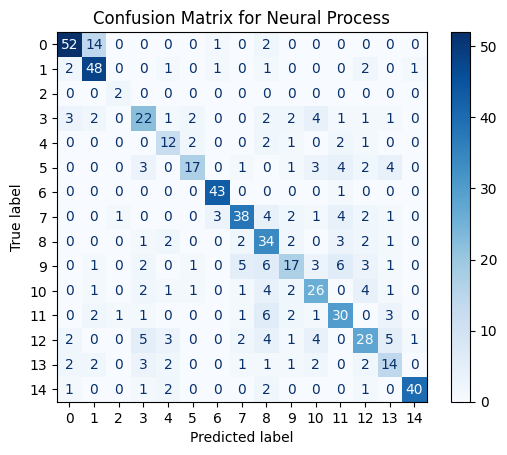

Uncertainties for Neural Process saved.


In [ ]:
# Evaluate the trained Neural Process (NP) model on the test dataset.

# Inference:
# - Use a fixed set of context data (e.g., the first 5 training samples) for predictions on the test set.
# - For each test query:
#   1. Perform a forward pass using the context and query features.
#   2. Predict the class with the highest softmax probability.
#   3. Estimate uncertainty using the standard deviation of the latent distribution.
#   4. Measure inference time per sample.

# Metrics:
# - Calculate overall accuracy of predictions.
# - Generate a confusion matrix to assess class-wise performance.
# - Perform timing analysis: count predictions exceeding a specified time threshold and compute average inference time.

# Visualization:
# - Display the confusion matrix for evaluation of model performance.

# Results:
# - Uncertainty estimates (latent standard deviations) are saved for further analysis.
# - Prints accuracy, timing metrics, and confusion matrix summary.

# Evaluation
neural_process.eval()

# Initialize metrics
all_predictions = []
all_true_labels = []
all_uncertainties = []
prediction_times = []

print("Testing Neural Process...")
with torch.no_grad():
    for query_x, true_y in zip(test_features, test_labels):
        query_x = query_x.unsqueeze(0).to(device)  # Add batch dimension for single-point prediction
        true_y = true_y.unsqueeze(0).to(device)  # Add batch dimension for true_y

        # Use a fixed set of context data
        context_x = train_features[:5].to(device)  # Use the first 5 training features as context
        context_y = train_labels[:5].to(device)  # Use the first 5 training labels as context

        # Timing inference
        start_time = time.time()

        # Forward pass with Neural Process
        query_pred, latent_dist = neural_process(context_x, context_y, query_x)

        # Prediction and uncertainty
        predicted_class = query_pred.softmax(dim=-1).argmax(dim=-1).item()
        uncertainty = latent_dist.stddev.mean().item()  # Use latent stddev as uncertainty

        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(inference_time)

        # Append predicted class
        all_predictions.append(predicted_class)

        # Store true label
        if len(true_y.shape) == 2 and true_y.size(-1) > 1:  # One-hot encoded
            true_label = true_y.argmax(dim=-1).item()
        else:  # Integer labels
            true_label = true_y.item()

        all_true_labels.append(true_label)

        # Store uncertainty
        all_uncertainties.append(uncertainty)


# Metrics
accuracy_NP = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
threshold = 1  # Define the threshold in milliseconds
times_exceeding_threshold_NP = sum(1 for t in prediction_times if t > threshold)
average_time_per_prediction_NP = np.mean(prediction_times)

# Output results
print(f"Accuracy with Neural Process: {accuracy_NP:.4f}")
print(f"Number of predictions taking longer than {threshold} ms: {times_exceeding_threshold_NP}")
print(f"Average time per prediction with Neural Process (ms): {average_time_per_prediction_NP:.4f}")

# Confusion matrix
class_names = range(num_classes)  # Class names
ConfusionMatrixDisplay.from_predictions(
    all_true_labels,
    all_predictions,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.title("Confusion Matrix for Neural Process")
plt.show()

# Save uncertainties for later use
uncertainties_np = np.array(all_uncertainties)
print("Uncertainties for Neural Process saved.")

In [ ]:
# Function to compute and print uncertainty statistics for various models.
# - `print_uncertainty_stats`: Calculates and displays summary statistics for uncertainty values.
#   - Min: The smallest uncertainty value.
#   - Max: The largest uncertainty value.
#   - Mean: The average uncertainty value.
#   - Median: The median (middle) uncertainty value.
#   - Std: The standard deviation, showing spread of uncertainties.

# Usage:
# - Assume `uncertainties_simpleNN`, `uncertainties_mc_dropout`, `uncertainties_bagging`, and `uncertainties_np`
#   are preloaded arrays containing uncertainty measures for the respective models.
# - Print summary statistics for each model to compare uncertainty performance.

# Function to compute and print statistics
def print_uncertainty_stats(model_name, uncertainties):
    print(f"Statistics for {model_name}:")
    print(f"  Min: {np.min(uncertainties):.4f}")
    print(f"  Max: {np.max(uncertainties):.4f}")
    print(f"  Mean: {np.mean(uncertainties):.4f}")
    print(f"  Median: {np.median(uncertainties):.4f}")
    print(f"  Std: {np.std(uncertainties):.4f}")
    print()

# Assume uncertainties_simpleNN, uncertainties_mc_dropout, uncertainties_bagging, uncertainties_np are preloaded

# Print statistics for each model
print_uncertainty_stats("SimpleNN", uncertainties_simpleNN)
print_uncertainty_stats("MC Dropout", uncertainties_mc_dropout)
print_uncertainty_stats("Bagging", uncertainties_bagging)
print_uncertainty_stats("NP", uncertainties_np)

Statistics for SimpleNN:
  Min: 0.0066
  Max: 0.0667
  Mean: 0.0473
  Median: 0.0504
  Std: 0.0178

Statistics for MC Dropout:
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Median: 0.0000
  Std: 0.0000

Statistics for Bagging:
  Min: 0.0000
  Max: 0.0206
  Mean: 0.0037
  Median: 0.0027
  Std: 0.0038

Statistics for NP:
  Min: 1.7667
  Max: 1.7667
  Mean: 1.7667
  Median: 1.7667
  Std: 0.0000



In [ ]:
# Rescale uncertainties to a common [0, 1] range for comparison and ensemble processing.

# Steps:
# 1. Combine uncertainties from `SimpleNN`, `MC Dropout`, and `Bagging` models to determine a shared range.
# 2. Rescale these uncertainties to the [0, 1] range based on the combined minimum and maximum values.
# 3. Rescale the Neural Process (NP) uncertainties independently, aligning with the range determined from the other models.

# Functions:
# - `rescale_to_unit_range`: Normalizes uncertainty values to the [0, 1] range using a given min and max.
# - `rescale_np_to_other_range`: Rescales NP uncertainties to align with the range of the first three models.

# Outputs:
# - Rescaled uncertainties for `SimpleNN`, `MC Dropout`, `Bagging`, and `NP` are saved as `.npy` files for reuse.
# - All rescaled uncertainties are combined into `all_uncertainties_scaled` for ensemble analysis.

# Debugging:
# - Prints rescaled uncertainties for each model to verify the normalization process.

# Results:
# - All uncertainties are rescaled consistently, allowing fair comparison and potential combination in ensemble techniques.

# Combine uncertainties from the first three models to determine the range
combined_uncertainties = np.concatenate([
    uncertainties_simpleNN,
    uncertainties_mc_dropout,
    uncertainties_bagging
])

# Find the minimum and maximum values across the first three models
min_val = np.min(combined_uncertainties)
max_val = np.max(combined_uncertainties)

# Rescale function to map values to [0, 1] using min and max
def rescale_to_unit_range(uncertainties, min_val, max_val):
    range_val = max_val - min_val
    if range_val == 0:  # Handle identical uncertainties
        return np.full_like(uncertainties, 0.5)  # Assign constant value if range is 0
    return (uncertainties - min_val) / range_val

# Rescale the first three models' uncertainties to [0, 1]
uncertainties_simpleNN_rescaled = rescale_to_unit_range(uncertainties_simpleNN, min_val, max_val)
uncertainties_mc_dropout_rescaled = rescale_to_unit_range(uncertainties_mc_dropout, min_val, max_val)
uncertainties_bagging_rescaled = rescale_to_unit_range(uncertainties_bagging, min_val, max_val)

# Adjust NP uncertainties to align with the range determined from other models
np_min = np.min(uncertainties_np)
np_max = np.max(uncertainties_np)

# Rescale NP uncertainties to the [0, 1] range determined by min_val and max_val
def rescale_np_to_other_range(uncertainties_np, min_val, max_val, np_min, np_max):
    np_range = np_max - np_min
    if np_range == 0:  # Handle identical NP uncertainties
        np_max += 0.0001
        np_range = 0.0001
    # First normalize NP to its own range [0, 1]
    normalized_np = (uncertainties_np - np_min) / np_range
    # Then scale to the range of [min_val, max_val] of the first three models
    return normalized_np * (max_val - min_val) + min_val

uncertainties_np_rescaled = rescale_np_to_other_range(
    uncertainties_np, min_val, max_val, np_min, np_max
)

# Save scaled uncertainties if needed
np.save("scaled_uncertainties_simpleNN.npy", uncertainties_simpleNN_rescaled)
np.save("scaled_uncertainties_mc_dropout.npy", uncertainties_mc_dropout_rescaled)
np.save("scaled_uncertainties_bagging.npy", uncertainties_bagging_rescaled)
np.save("scaled_uncertainties_np.npy", uncertainties_np_rescaled)

# Combine scaled uncertainties for the ensemble
all_uncertainties_scaled = [
    uncertainties_simpleNN_rescaled,
    uncertainties_mc_dropout_rescaled,
    uncertainties_bagging_rescaled,
    uncertainties_np_rescaled
]

# Debug output for verification
print("SimpleNN Rescaled:", uncertainties_simpleNN_rescaled)
print("MC Dropout Rescaled:", uncertainties_mc_dropout_rescaled)
print("Bagging Rescaled:", uncertainties_bagging_rescaled)
print("NP Rescaled:", uncertainties_np_rescaled)

uncertainties_simpleNN = uncertainties_simpleNN_rescaled
uncertainties_mc_dropout = uncertainties_mc_dropout_rescaled
uncertainties_bagging = uncertainties_bagging_rescaled
uncertainties_np = uncertainties_np_rescaled

SimpleNN Rescaled: [0.34999835 0.6532334  0.9979969  0.983243   0.9292857  0.9964311
 0.9964454  0.99950236 0.97893596 0.9993603  0.9996218  0.6457393
 0.9979946  0.73583615 0.73583615 0.99898756 0.9996577  0.9979121
 0.9567721  0.99431974 0.99659586 0.97770125 0.97606105 0.95992243
 0.9838738  0.99961007 0.93446755 0.8692148  0.98497796 0.95007986
 0.9908823  0.9835233  0.9112217  0.9773158  0.9993081  0.9993081
 0.9569835  0.9984451  0.9874526  0.9874526  0.24338481 0.5437326
 0.38196626 0.84952325 0.5591859  0.56225127 0.9528459  0.863277
 0.9902382  0.9777152  0.8621221  0.4336299  0.5248086  0.99039054
 0.88036346 0.98176557 0.9198168  0.99160874 0.5102567  0.629673
 0.33219594 0.97035253 0.4709499  0.9873423  0.7364387  0.40567952
 0.2659351  0.98151267 0.9741813  0.92185456 0.90733534 0.5489274
 0.93055755 0.9050842  0.8612129  0.9874019  0.9723621  0.7033591
 0.849832   0.94977117 0.87646776 0.9280555  0.7505606  0.64384
 0.81414115 0.68298554 0.49369425 0.47974932 0.77058816 0

In [24]:
# Print statistics for each model
print_uncertainty_stats("SimpleNN", uncertainties_simpleNN)
print_uncertainty_stats("MC Dropout", uncertainties_mc_dropout)
print_uncertainty_stats("Bagging", uncertainties_bagging)
print_uncertainty_stats("NP", uncertainties_np)

Statistics for SimpleNN:
  Min: 0.0993
  Max: 1.0000
  Mean: 0.7096
  Median: 0.7561
  Std: 0.2675

Statistics for MC Dropout:
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Median: 0.0000
  Std: 0.0000

Statistics for Bagging:
  Min: 0.0000
  Max: 0.3085
  Mean: 0.0549
  Median: 0.0408
  Std: 0.0575

Statistics for NP:
  Min: 0.0000
  Max: 0.0000
  Mean: 0.0000
  Median: 0.0000
  Std: 0.0000



Testing Combination Model...
Accuracy with Combination Model: 0.6499
Number of predictions taking longer than 1 ms: 637
Average time per prediction with Combination Model (ms): 3.8270


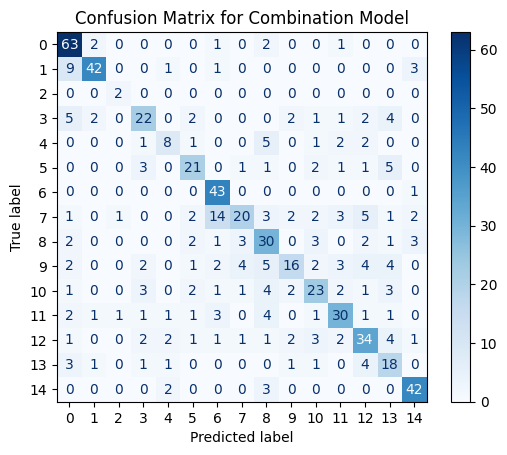

Weight proportions saved for each model.


In [ ]:
# Combination Model Evaluation: Integrating predictions and uncertainties from MC Dropout, Bagging Ensemble, and Neural Process.

# Steps:
# 1. Reload all pre-trained models (MC Dropout, Bagging Ensemble, Neural Process) and prepare for inference.
# 2. Perform inference on each test sample:
#    - MC Dropout: Use multiple stochastic forward passes to compute mean prediction and variance (uncertainty).
#    - Bagging Ensemble: Aggregate predictions from all ensemble members, computing mean prediction and variance.
#    - Neural Process: Predict using a fixed context set, computing mean prediction and latent uncertainty.
# 3. Rescale uncertainties to a common range, normalize weights using a temperature-scaled exponential function.
# 4. Combine predictions using weighted averaging of probability distributions.
# 5. Compute overall uncertainty as a weighted average of individual model uncertainties.

# Metrics:
# - Calculate overall accuracy and generate a confusion matrix for the combined model.
# - Perform timing analysis: identify predictions exceeding a specified time threshold and compute average time.

# Outputs:
# - Accuracy, timing metrics, and a confusion matrix summarizing the model's performance.
# - Save weight proportions (for each model) and combination uncertainties for further analysis.

# Key Features:
# - Combines diverse models for robust predictions, leveraging uncertainty-based weighting.
# - Provides detailed uncertainty estimation and timing analysis for each test prediction.
# - Visualization of results through a confusion matrix and numerical summary.

input_dim = test_features.shape[1]  # Get feature dimension from extracted features

# Initialize MC Dropout model with input_dim
model_mc_dropout = SimpleCNN(input_dim=input_dim, num_classes=num_classes).to(device)
model_mc_dropout.load_state_dict(torch.load("simple_cnn_weights.pth", map_location=device))  # Reload saved weights
model_mc_dropout.eval()  # Set to evaluation mode
enable_dropout(model_mc_dropout)  # Enable dropout for stochastic predictions

# Reload Bagging Ensemble
bagging_ensemble = []
n_models = 10  # Number of ensemble models
ensemble_dir = "bagging_ensemble_weights"  # Directory where ensemble weights are saved
for i in range(1, n_models + 1):
    bagging_model = SmallerCNN(input_dim=input_dim, num_classes=num_classes).to(device)
    bagging_model.load_state_dict(torch.load(f"{ensemble_dir}/model_{i}.pth", map_location=device))
    bagging_model.eval()
    bagging_ensemble.append(bagging_model)

# Reload Neural Process model
neural_process = NeuralProcess(input_dim=input_dim, hidden_dim=1024, latent_dim=128, output_dim=num_classes).to(device)
neural_process.load_state_dict(torch.load("best_neural_process.pth", map_location=device))  # Load NP weights
neural_process.eval()

# Initialize test results
all_predictions = []
all_true_labels = []
all_combination_uncertainties = []  # Final uncertainty (entropy)
prediction_times = []  # Time for each combined prediction
model_weights = []  # Stores weight proportions for each model

# Number of stochastic passes for MC Dropout
n_passes = 50

# Testing the combination model
print("Testing Combination Model...")
with torch.no_grad():
    for idx, (x, y) in enumerate(zip(test_features, test_labels)):
        x, y = x.to(device), y.to(device)  # Move data to device

        # Neural Process Context Data
        context_x = train_features[:5].to(device)  # Select 5 random context points
        context_y = train_labels[:5].to(device)

        # Start timing
        start_time = time.time()

        # Step 1: MC Dropout Prediction
        mc_dropout_outputs = []
        for _ in range(n_passes):
            logits = model_mc_dropout(x.unsqueeze(0))  # Add batch dimension for single-point prediction
            probabilities = F.softmax(logits, dim=1)
            mc_dropout_outputs.append(probabilities.cpu().numpy())
        mc_dropout_outputs = np.array(mc_dropout_outputs)
        mc_mean_prediction = mc_dropout_outputs.mean(axis=0)[0]
        mc_uncertainty = mc_dropout_outputs.var(axis=0).mean()

        # Step 2: Bagging Ensemble Prediction
        bagging_outputs = []
        for model in bagging_ensemble:
            logits = model(x.unsqueeze(0))  # Add batch dimension
            probabilities = F.softmax(logits, dim=1)
            bagging_outputs.append(probabilities.cpu().numpy())
        bagging_outputs = np.array(bagging_outputs)
        bagging_mean_prediction = bagging_outputs.mean(axis=0)[0]
        bagging_uncertainty = bagging_outputs.var(axis=0).mean()

        # Step 3: Neural Process Prediction
        query_x = x.unsqueeze(0)  # Add batch dimension
        query_pred, latent_dist = neural_process(context_x, context_y, query_x)

        np_mean_prediction = F.softmax(query_pred, dim=1).cpu().numpy()[0]
        np_uncertainty = latent_dist.stddev.mean().item()  # Latent uncertainty (use latent stddev)

        # Handle cases where NP uncertainties might have no range
        np_min = np.min(np.array([np_uncertainty]))  # Single value or computed dynamically
        np_max = np.max(np.array([np_uncertainty]))  # Single value or computed dynamically

        # Rescale NP uncertainties with adjusted range logic
        np_uncertainty_rescaled = rescale_np_to_other_range(
            np.array([np_uncertainty]), min_val, max_val, np_min, np_max
        )[0]

        # Step 4: Combine predictions based on uncertainty
        temperature = 0.25  # Smaller values make scaling more aggressive
        uncertainties = np.array([mc_uncertainty, bagging_uncertainty, np_uncertainty_rescaled])
        weights = np.exp(-uncertainties / temperature)  # Apply temperature scaling
        normalized_weights = weights / weights.sum()  # Normalize weights

        # Weighted average of probability distributions
        combined_prediction = (
            normalized_weights[0] * mc_mean_prediction +
            normalized_weights[1] * bagging_mean_prediction +
            normalized_weights[2] * np_mean_prediction
        )

        # Final class prediction
        predicted_class = np.argmax(combined_prediction)

        # Step 5: Compute overall uncertainty as a weighted average
        combined_uncertainty = np.dot(normalized_weights, uncertainties)

        # End timing
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(prediction_time)

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y.item())
        all_combination_uncertainties.append(combined_uncertainty)
        model_weights.append(normalized_weights)


# Metrics
accuracy_Combine = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
threshold = 1  # Define the threshold in milliseconds
times_exceeding_threshold_Combine = sum(1 for t in prediction_times if t > threshold)
average_time_per_prediction_Combine = np.mean(prediction_times)

# Output results
print(f"Accuracy with Combination Model: {accuracy_Combine:.4f}")
print(f"Number of predictions taking longer than {threshold} ms: {times_exceeding_threshold_Combine}")
print(f"Average time per prediction with Combination Model (ms): {average_time_per_prediction_Combine:.4f}")

# Confusion matrix
class_names = train_dataset.classes if hasattr(train_dataset, "classes") else range(num_classes)  # Class names
ConfusionMatrixDisplay.from_predictions(
    all_true_labels,
    all_predictions,
    display_labels=class_names,
    cmap=plt.cm.Blues,
)
plt.title("Confusion Matrix for Combination Model")
plt.show()

# Save weights proportions and combination uncertainties for later analysis
model_weights = np.array(model_weights)
print("Weight proportions saved for each model.")

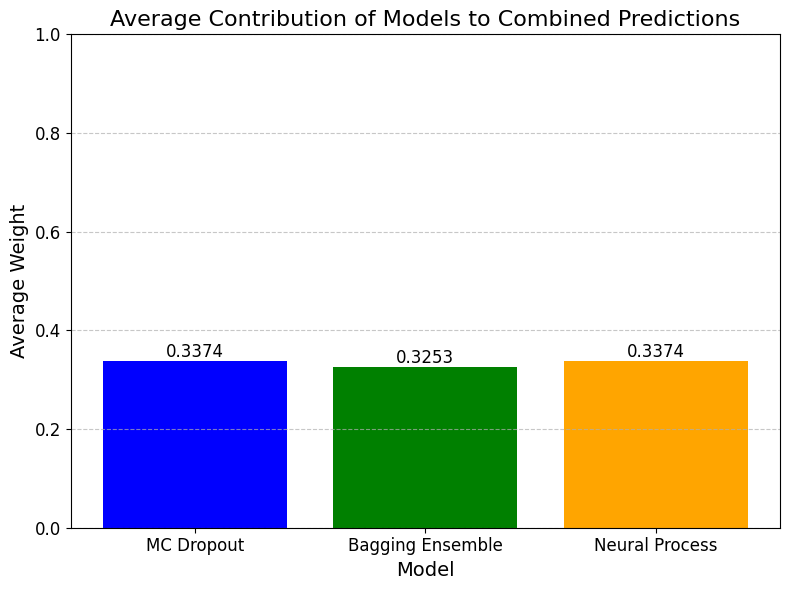

In [27]:
# Compute average contribution of each model across all predictions
average_weights = model_weights.mean(axis=0)

# Labels for the models
model_names = ['MC Dropout', 'Bagging Ensemble', 'Neural Process']  # Updated to replace Sparse GP

# Plotting the contributions
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, average_weights, color=['blue', 'green', 'orange'])

# Add exact values above each bar
for bar, weight in zip(bars, average_weights):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{weight:.4f}', ha='center', va='bottom', fontsize=12)

plt.title('Average Contribution of Models to Combined Predictions', fontsize=16)
plt.ylabel('Average Weight', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Weights are normalized, so they should sum to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the graph
plt.tight_layout()
plt.show()

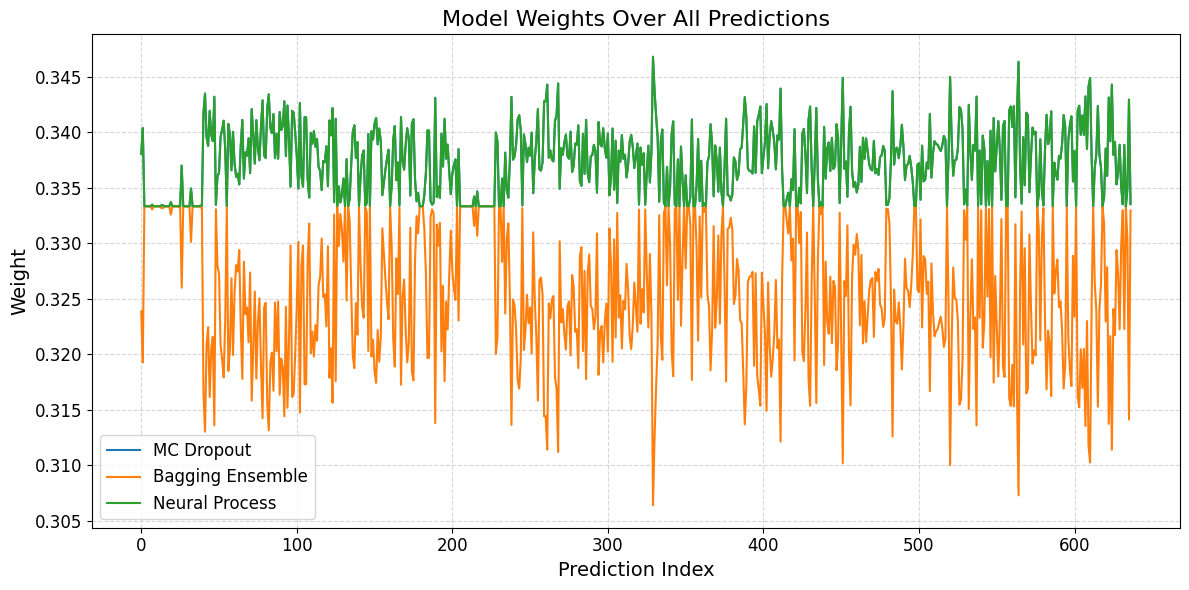

In [28]:
# Assume model_weights is a NumPy array of shape (num_samples, num_models)
# Rows correspond to test samples, columns correspond to model weights (MC Dropout, Bagging, Neural Process)

# Labels for the models
model_names = ['MC Dropout', 'Bagging Ensemble', 'Neural Process']  # Updated to replace Sparse GP

# Plotting weights for all predictions
plt.figure(figsize=(12, 6))

for i, model_name in enumerate(model_names):
    plt.plot(model_weights[:, i], label=model_name, linewidth=1.5)

plt.title('Model Weights Over All Predictions', fontsize=16)
plt.xlabel('Prediction Index', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# Display the graph
plt.show()

Spread of Weights for Each Model:
              Model       Min       Max      Mean    Median       Std
0        MC Dropout  0.333333  0.346800  0.337373  0.337531  0.003049
1  Bagging Ensemble  0.306400  0.333333  0.325254  0.324937  0.006098
2    Neural Process  0.333333  0.346800  0.337373  0.337531  0.003049


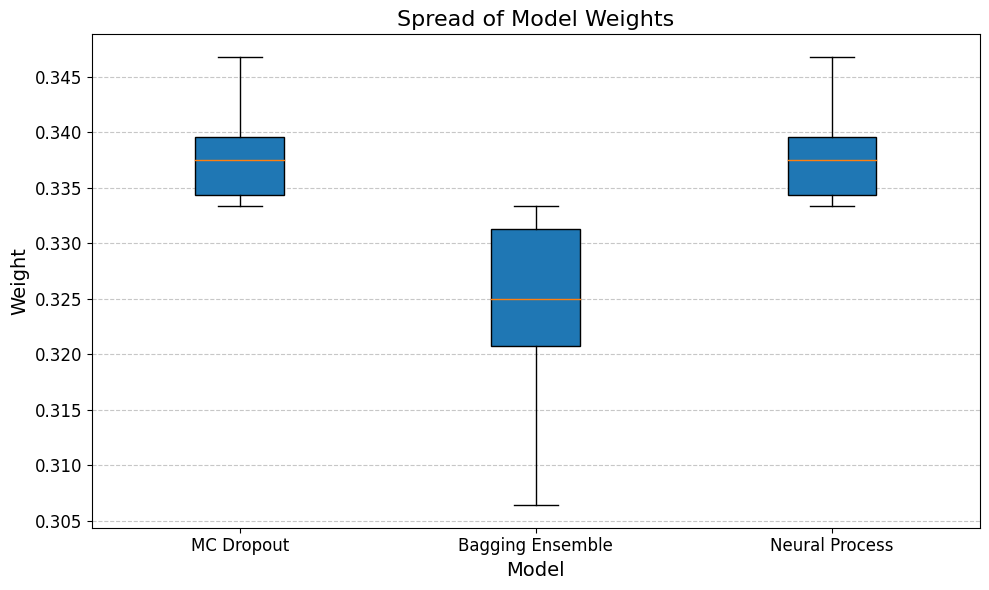

In [29]:
# Calculate statistics for each model's weights

# Create a DataFrame for better organization
weight_stats = {
    'Model': ['MC Dropout', 'Bagging Ensemble', 'Neural Process'],  # Updated to replace Sparse GP
    'Min': model_weights.min(axis=0),
    'Max': model_weights.max(axis=0),
    'Mean': model_weights.mean(axis=0),
    'Median': np.median(model_weights, axis=0),
    'Std': model_weights.std(axis=0),
}

# Convert to DataFrame for display
weight_stats_df = pd.DataFrame(weight_stats)

# Display statistics
print("Spread of Weights for Each Model:")
print(weight_stats_df)

# Plot box plots for each model's weights
plt.figure(figsize=(10, 6))

# Pass model_weights (not transposed) to match labels
plt.boxplot(model_weights, labels=['MC Dropout', 'Bagging Ensemble', 'Neural Process'], patch_artist=True)

plt.title('Spread of Model Weights', fontsize=16)
plt.ylabel('Weight', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

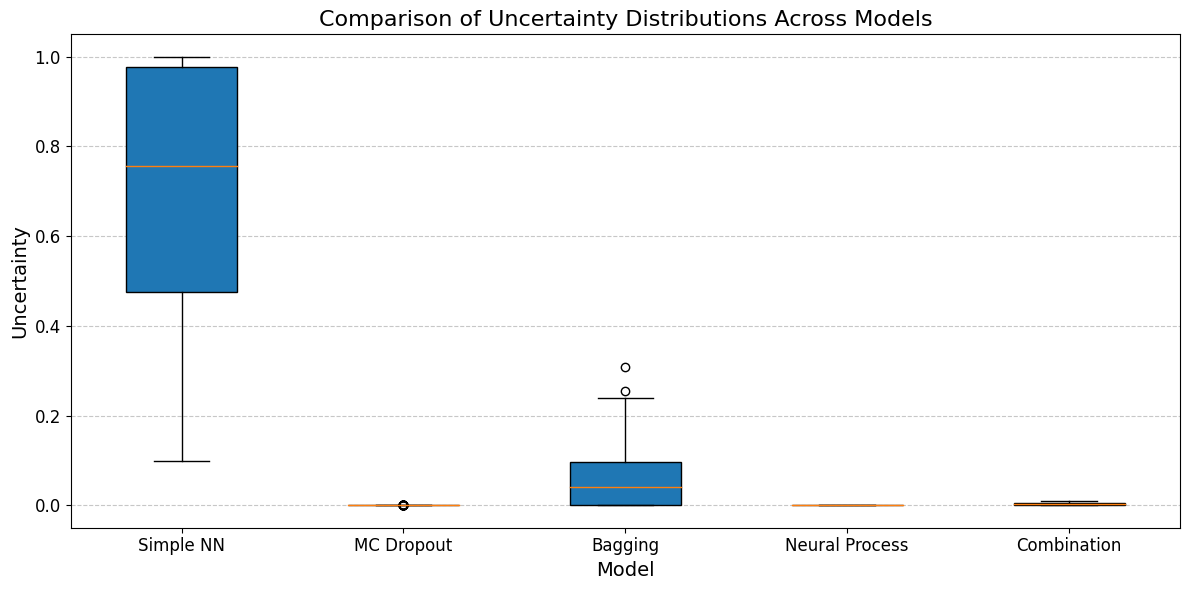

In [30]:
# Combine uncertainties into a single list for boxplot
all_uncertainties = [
    uncertainties_simpleNN,
    uncertainties_mc_dropout,
    uncertainties_bagging,
    uncertainties_np,
    all_combination_uncertainties
]

# Labels for the boxplots
model_labels = ['Simple NN', 'MC Dropout', 'Bagging', 'Neural Process', 'Combination']

# Plot boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(all_uncertainties, labels=model_labels, patch_artist=True)

plt.title('Comparison of Uncertainty Distributions Across Models', fontsize=16)
plt.ylabel('Uncertainty', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()

In [31]:
# Data for the table
model_names = ['Simple NN', 'MC Dropout', 'Bagging', 'Neural Process', 'Combination']
accuracies = [
    accuracy_NN,
    accuracy_MC,
    accuracy_Bag,
    accuracy_NP,
    accuracy_Combine
]
times_exceeding_125ms = [
    times_exceeding_threshold_NN,
    times_exceeding_threshold_MC,
    times_exceeding_threshold_Bag,
    times_exceeding_threshold_NP,
    times_exceeding_threshold_Combine
]
average_times = [
    average_time_per_prediction_NN,
    average_time_per_prediction_MC,
    average_time_per_prediction_Bag,
    average_time_per_prediction_NP,
    average_time_per_prediction_Combine
]
# Calculate average uncertainties
average_uncertainties = [
    np.mean(uncertainties_simpleNN),
    np.mean(uncertainties_mc_dropout),
    np.mean(uncertainties_bagging),
    np.mean(uncertainties_np),
    np.mean(all_combination_uncertainties)
]

# Create a DataFrame
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Times >1ms': times_exceeding_125ms,
    'Avg Time (ms)': average_times,
    'Avg Uncertainty': average_uncertainties
})

# Print for reference in the notebook
print(comparison_table)

            Model  Accuracy  Times >1ms  Avg Time (ms)  Avg Uncertainty
0       Simple NN  0.678179           0       0.012625     7.096193e-01
1      MC Dropout  0.678179           0       0.381658     1.021669e-13
2         Bagging  0.690738           0       0.068637     5.492162e-02
3  Neural Process  0.664050         302       0.557899     1.052022e-30
4     Combination  0.649922         637       3.827016     2.943344e-03
